## 1. Cài đặt và import các thư viện

In [3]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import warnings

warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"


## 2. Đọc và khám phá bộ dữ liệu

In [4]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")
ds

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [6]:
# print three first examples
for i in range(3):
    print(f"Example {i+1}:")
    print(ds['train'][i]['abstract'])
    print("---" * 20)
    print(ds['train'][i]['categories'])
    print("---" * 20)


Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

-----

In [7]:
all_categories = ds['train']['categories']
print(set(all_categories))

Output hidden; open in https://colab.research.google.com to view.

In [8]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories = sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)


There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [9]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']

for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break

print(f"Number of samples: {len(samples)}")  # Number of samples: 1000


Number of samples: 1000


## 3. Tiền xử lý dữ liệu

In [10]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })


In [12]:
sorted_labels = sorted(CATEGORIES_TO_SELECT, key=lambda x: x.lower())

label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id in label_to_id.items():
    print(f"{label} --> {id}")


Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [13]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 800
Test samples: 200


## 4. Mã hóa văn bản

### 4.1 Bag-of-Words

#### Example

In [14]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)

for i, vec in enumerate(vectors):
    print(f"Document {i+1}: {vec.toarray()}")


Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


### 4.2 TF-IDF

#### Example

In [17]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = TfidfVectorizer()
tfidf_vector = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vector):
    print(f"TF-IDF for Document {i+1}:")
    print(vec.toarray())


TF-IDF for Document 1:
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF-IDF for Document 2:
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF-IDF for Document 3:
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.

### 4.3 Sentence Embeddings

#### Example

In [20]:
class EmbeddingVectorizer:
    def __init__(
        self,
        model_name: str = 'intfloat/multilingual-e5-base',
        normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self,
        texts: List[str],
        mode: Literal['query', 'passage']
    ):
        if mode not in ['query', 'passage']:
            raise ValueError("mode must be either 'query' or 'passage'")
        return [f"{mode}: {text.strip()}" for text in texts]

    def fit_transform(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ):
        if mode == 'raw':
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self,
        texts: List[str],
        mode: Literal['query', 'passage'] = 'query'
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))


In [21]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities."
]

vectorizer = EmbeddingVectorizer()
embeddings = vectorizer.fit_transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i+1}:")
    print(emb[:3]) # Print first 10 dimensions for brevity

Embedding for Document 1:
[-0.014805685728788376, 0.031276602298021317, -0.01615864969789982]
Embedding for Document 2:
[0.01191739086061716, 0.03327367454767227, -0.025738948956131935]
Embedding for Document 3:
[0.012662852182984352, 0.039361219853162766, -0.024181142449378967]
Embedding for Document 4:
[0.0063935876823961735, 0.04922204092144966, -0.02840282768011093]


### 4.4 Khai báo và khởi tạo các vectorizes

In [22]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.fit_transform(X_train)
X_test_embeddings = embedding_vectorizer.fit_transform(X_test)

# convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())
X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

# Print shapes of the transformed datasets
print(f'Shape of X_train_bow: {X_train_bow.shape}\n')
print(f'Shape of X_test_bow: {X_test_bow.shape}\n')
print(f'Shape of X_train_tfidf: {X_train_tfidf.shape}\n')
print(f'Shape of X_test_tfidf: {X_test_tfidf.shape}\n')
print(f'Shape of X_train_embeddings: {X_train_embeddings.shape}\n')
print(f'Shape of X_test_embeddings: {X_test_embeddings.shape}\n')


Shape of X_train_bow: (800, 10373)

Shape of X_test_bow: (200, 10373)

Shape of X_train_tfidf: (800, 10373)

Shape of X_test_tfidf: (200, 10373)

Shape of X_train_embeddings: (800, 768)

Shape of X_test_embeddings: (200, 768)



## 5. Huấn luyện và đánh giá mô hình phân loại

### 5.1 KMeans Clustering

In [23]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters=5):
    """
    Train KMeans on X_train, assign each cluster the most common true label,
    predict labels for X_test, and return predictions, accuracy, and report dict.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters (most common label in each cluster)
    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    # Predict labels for test set
    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test,
        y_pred,
        target_names=[id_to_label[i] for i in range(len(id_to_label))],
        output_dict=True
    )

    return y_pred, accuracy, report

In [25]:
# Run K-Means on different vectorized datasets (unpack all three returned values)
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id)
)

km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id)
)

km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(
    X_train_embeddings, y_train, X_test_embeddings, y_test, n_clusters=len(label_to_id)
)

# Print K-Means results
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")


Bag of Words: 0.5600
TF-IDF: 0.6150
Embeddings: 0.8400


In [26]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
    """
    Plot confusion matrix with raw counts and normalized values.
    label_list can be a list of label names indexed by class id or a dict id->name.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    # handle division by zero rows
    cm_norm = np.nan_to_num(cm_norm)

    # map indices to names
    if isinstance(label_list, dict):
        labels = [label_list[i] for i in range(len(label_list))]
    else:
        labels = list(label_list)

    # create annotations combining raw and normalized
    annotations = np.empty_like(cm).astype(object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f"{cm[i, j]}\n{cm_norm[i, j]:.2f}"

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=annotations, fmt="", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()


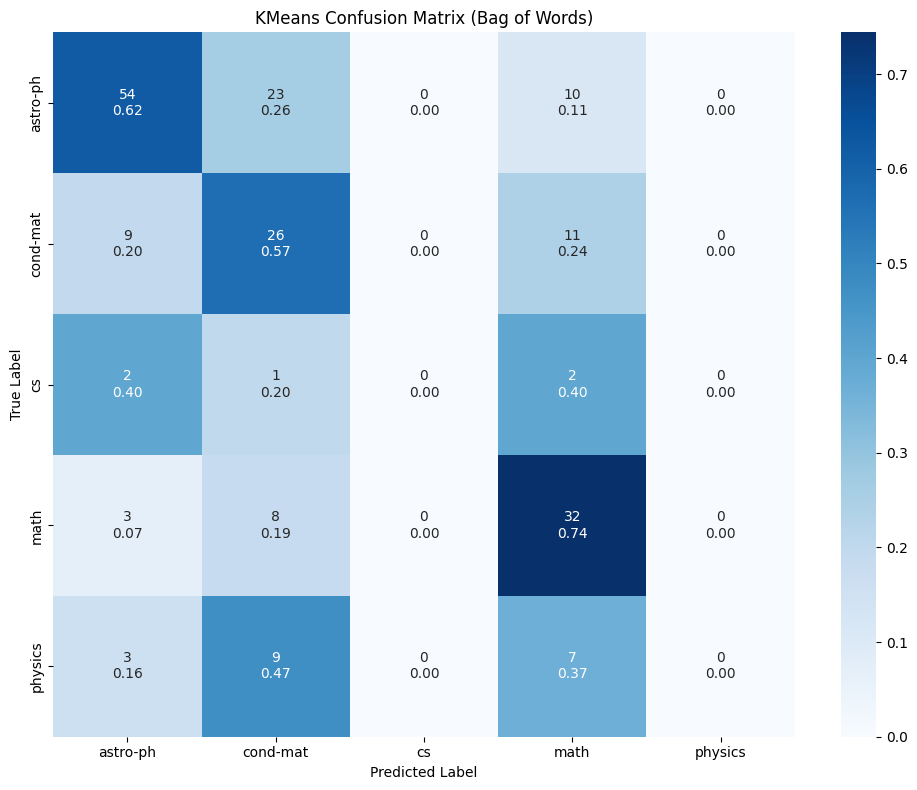

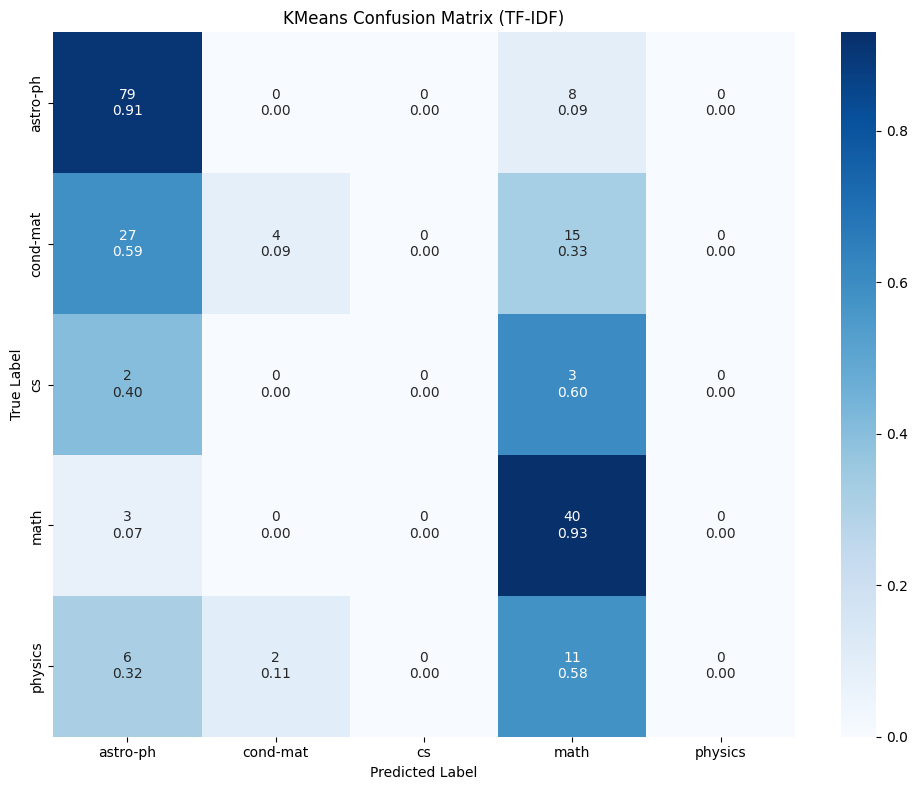

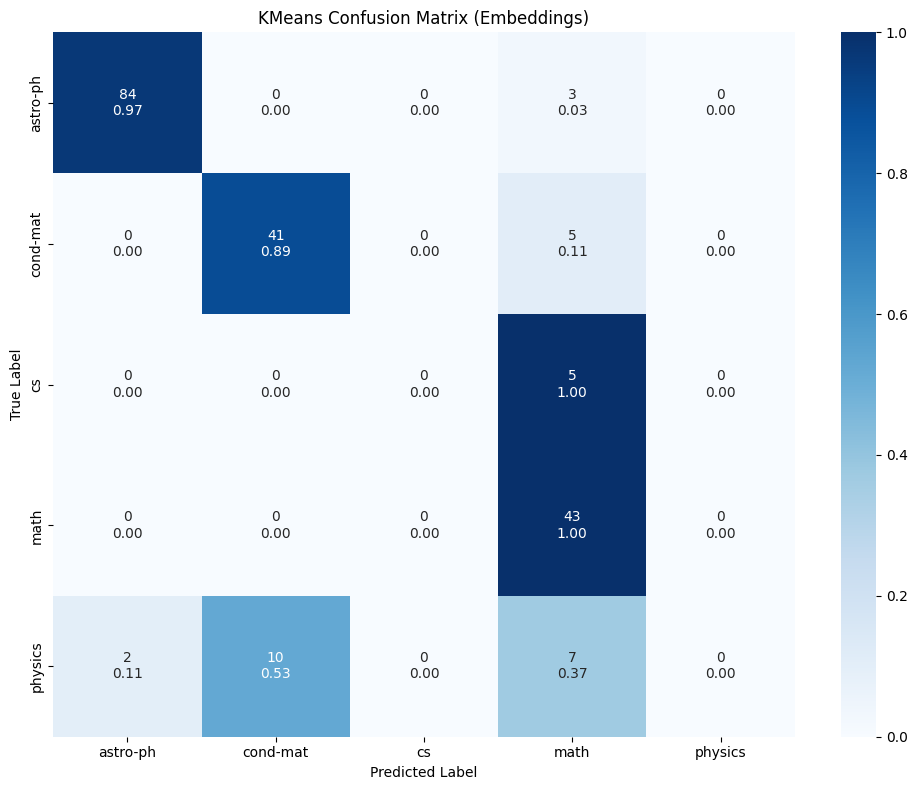

In [27]:
# Draw confusion matrices
plot_confusion_matrix(y_test, km_bow_labels, sorted_labels, "KMeans Confusion Matrix (Bag of Words)")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_labels, "KMeans Confusion Matrix (TF-IDF)")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_labels, "KMeans Confusion Matrix (Embeddings)")

### 5.2 K-Nearest Neighbors (KNN)

In [28]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test,
        y_pred,
        target_names=sorted_labels,
        output_dict=True
    )

    return y_pred, accuracy, report


In [29]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(
    X_train_bow, y_train, X_test_bow, y_test
)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(
    X_train_tfidf, y_train, X_test_tfidf, y_test
)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(
    X_train_embeddings, y_train, X_test_embeddings, y_test
)

# Print KNN results
print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")


Accuracies for KNN:
Bag of Words: 0.5300
TF-IDF: 0.8150
Embeddings: 0.8900


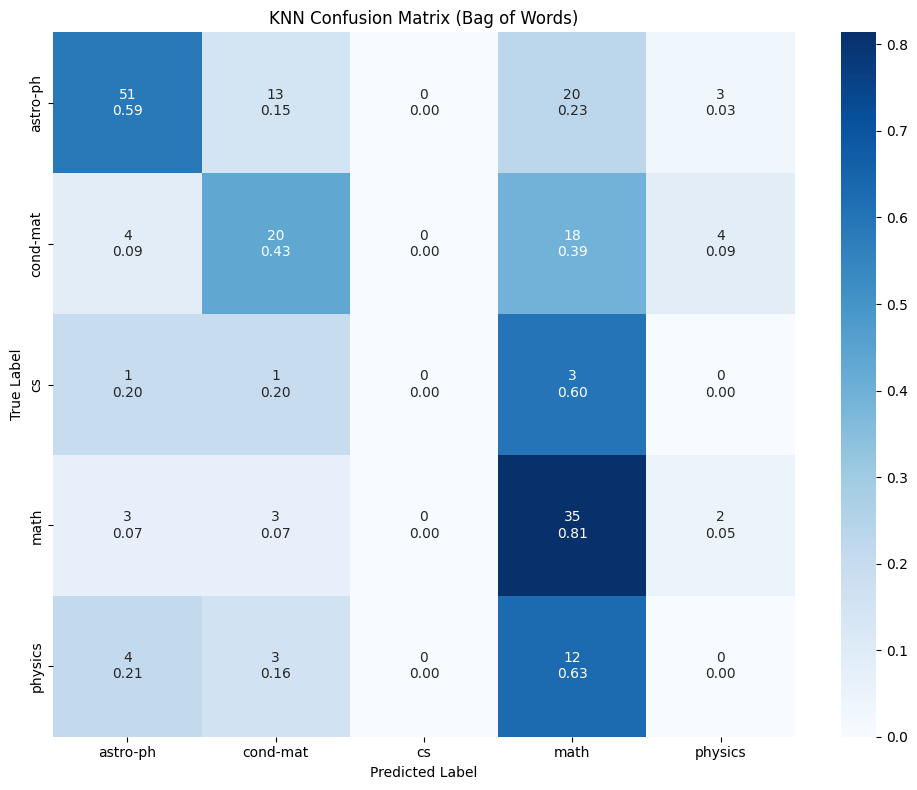

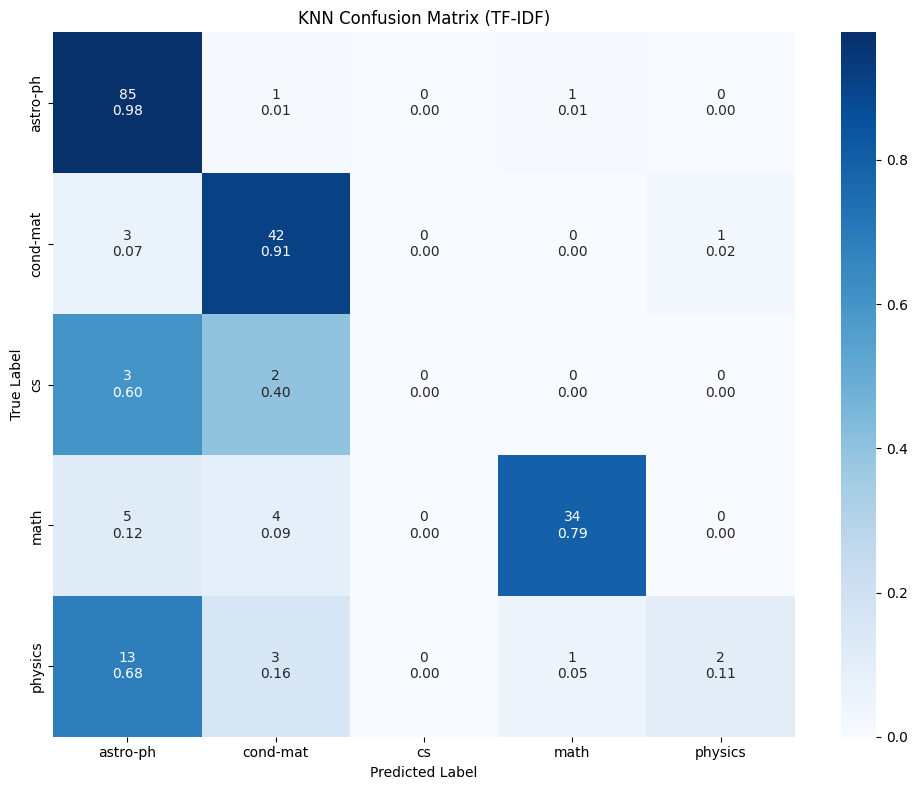

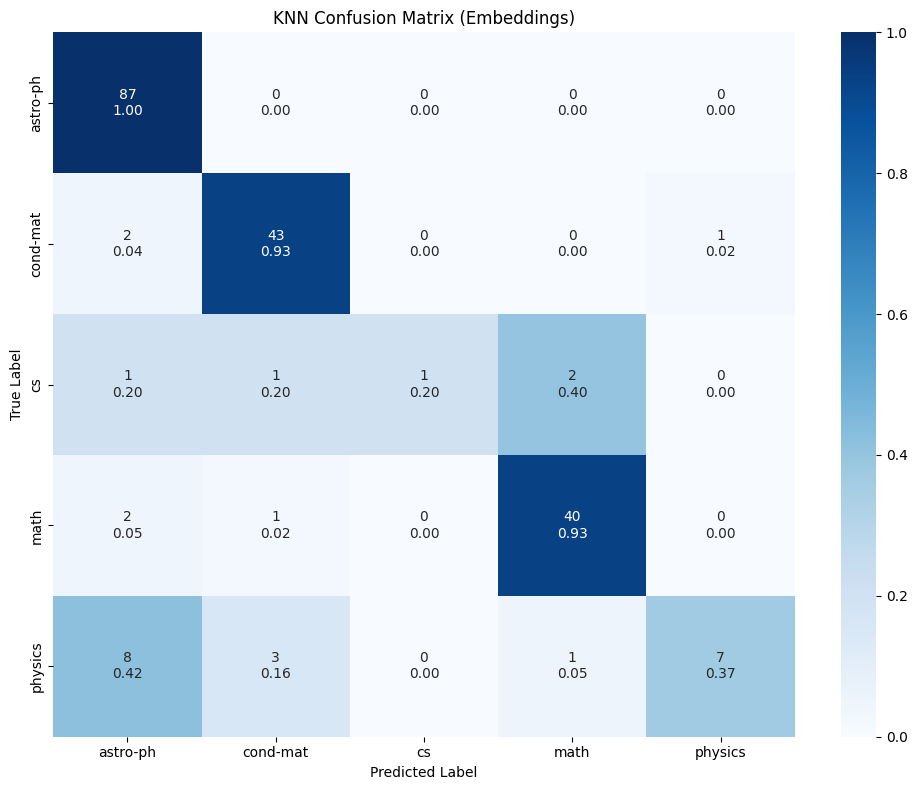

In [31]:
plot_confusion_matrix(y_test, knn_bow_labels, sorted_labels, "KNN Confusion Matrix (Bag of Words)")
plot_confusion_matrix(y_test, knn_tfidf_labels, sorted_labels, "KNN Confusion Matrix (TF-IDF)")
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "KNN Confusion Matrix (Embeddings)")

### 5.3 Desicion Tree

In [32]:
def train_and_test_desicion_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred = dt.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test,
        y_pred,
        target_names=sorted_labels,
        output_dict=True
    )
    return y_pred, accuracy, report

In [42]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    """
    Train a DecisionTreeClassifier on X_train/y_train, predict on X_test,
    and return (y_pred, accuracy, report_dict).
    kwargs are passed to DecisionTreeClassifier (e.g., max_depth, random_state).
    """
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test,
        y_pred,
        target_names=sorted_labels,
        output_dict=True
    )

    return y_pred, accuracy, report


In [43]:
# Train and test Decision Tree with different feature sets
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(
    X_train_bow, y_train, X_test_bow, y_test)

dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(
    X_train_tfidf, y_train, X_test_tfidf, y_test)

dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(
    X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Decision Tree results
print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6250
TF-IDF: 0.6150
Embeddings: 0.6400


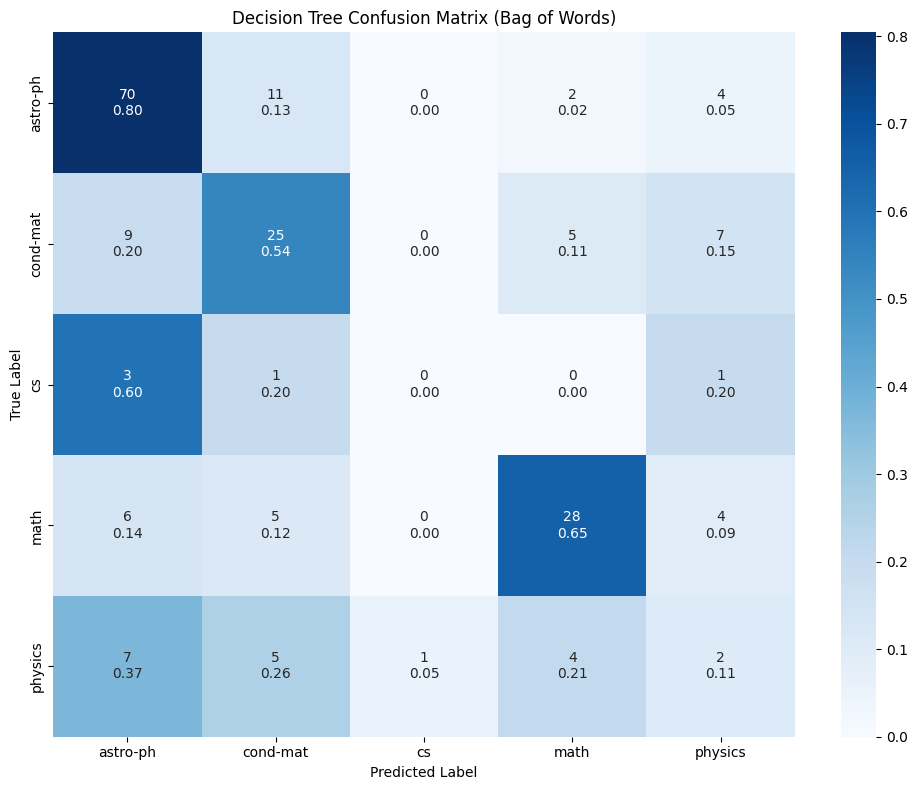

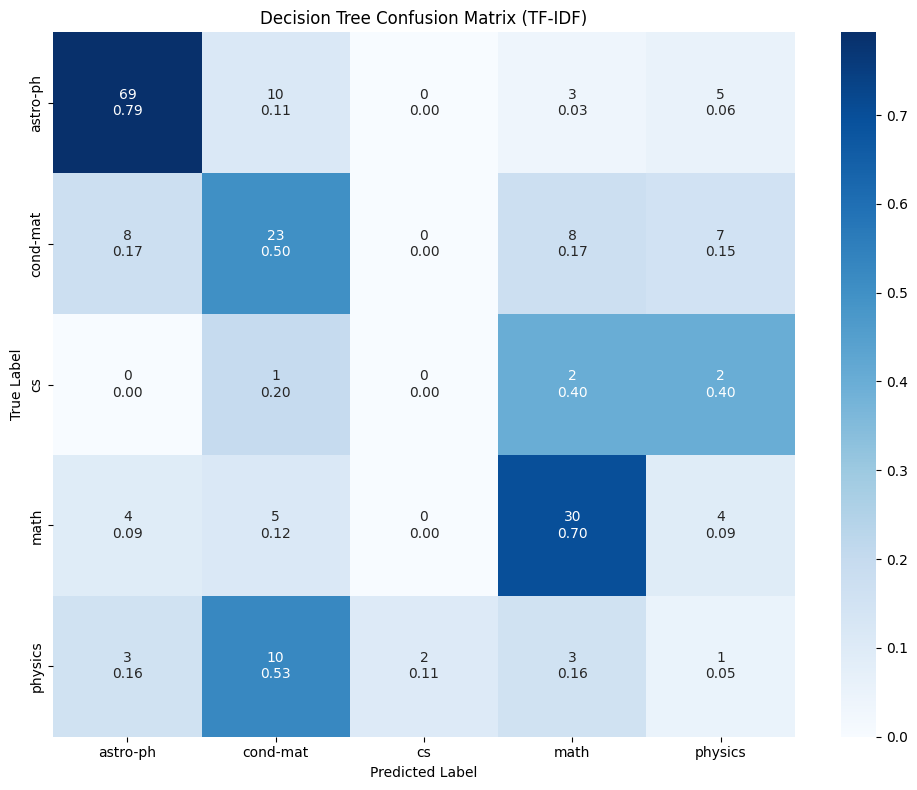

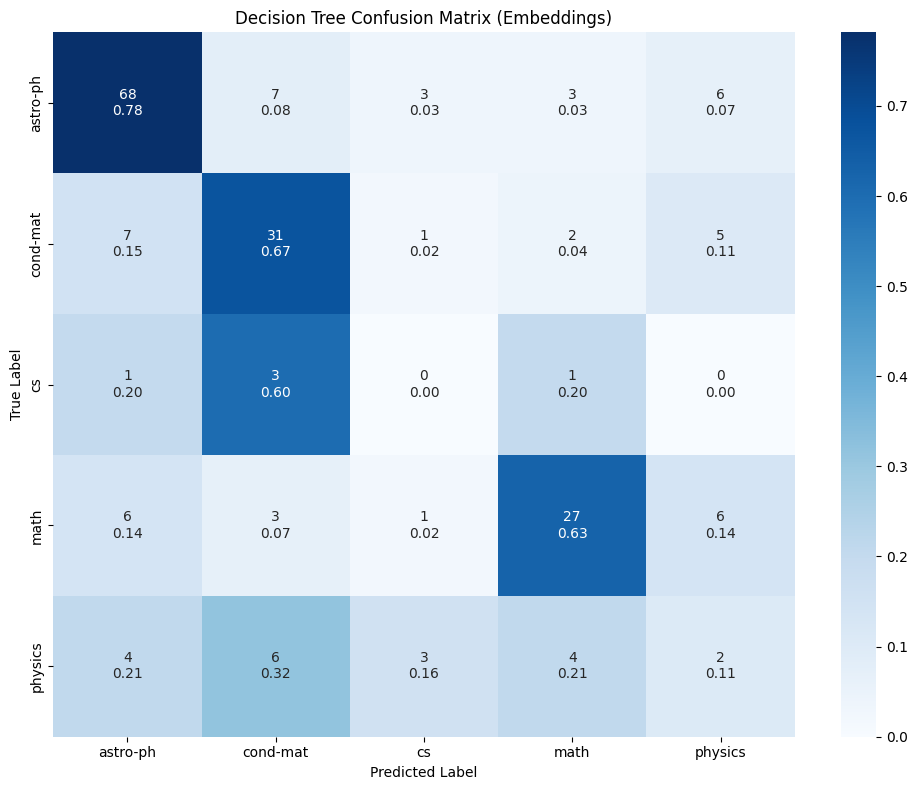

In [44]:
# Draw confusion matrices
plot_confusion_matrix(y_test, dt_bow_labels, sorted_labels, "Decision Tree Confusion Matrix (Bag of Words)")

plot_confusion_matrix(y_test, dt_tfidf_labels, sorted_labels, "Decision Tree Confusion Matrix (TF-IDF)")

plot_confusion_matrix(y_test, dt_embeddings_labels, sorted_labels, "Decision Tree Confusion Matrix (Embeddings)")


### 5.4 Naive Bayes

In [40]:
def train_and_test_naive_bayes(X_train, y_train, X_test, y_test):
    nb = GaussianNB()

    X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    nb.fit(X_train_dense, y_train)
    y_pred = nb.predict(X_test_dense)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [41]:
# Train and test Naive Bayes on different vectorized datasets
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naive_bayes(
    X_train_bow, y_train, X_test_bow, y_test)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naive_bayes(
    X_train_tfidf, y_train, X_test_tfidf, y_test)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naive_bayes(
    X_train_embeddings, y_train, X_test_embeddings, y_test)

# Print Naive Bayes results
print("Accuracies for Naive Bayes:")
print(f"Bag of Words: {nb_bow_accuracy:.4f}")
print(f"TF-IDF: {nb_tfidf_accuracy:.4f}")
print(f"Embeddings: {nb_embeddings_accuracy:.4f}")


Accuracies for Naive Bayes:
Bag of Words: 0.8500
TF-IDF: 0.8300
Embeddings: 0.8900


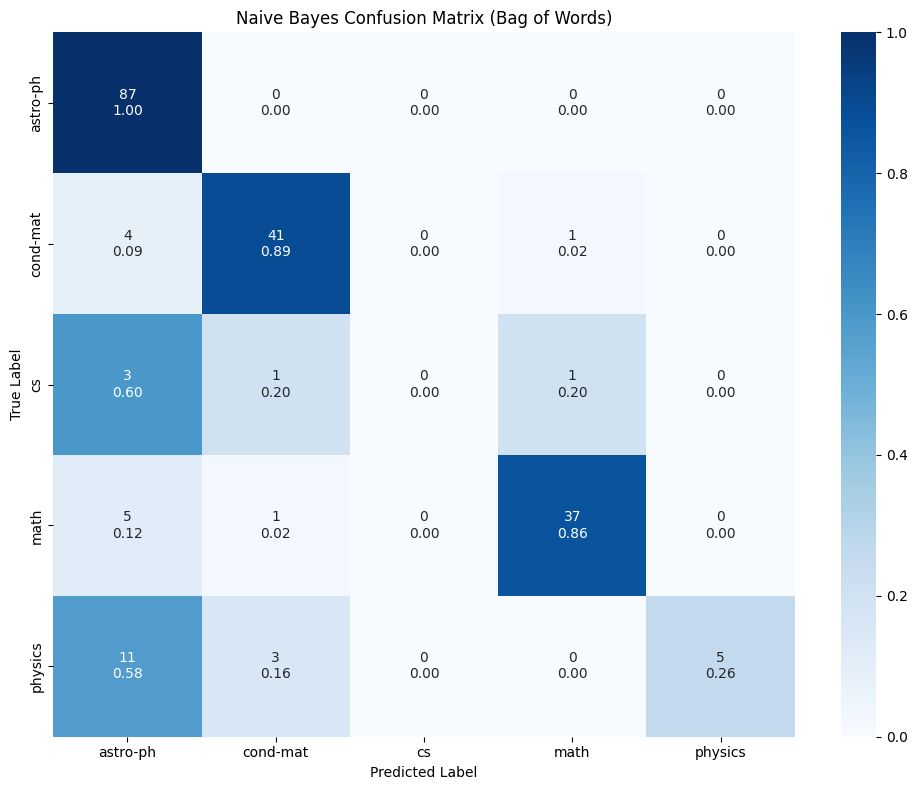

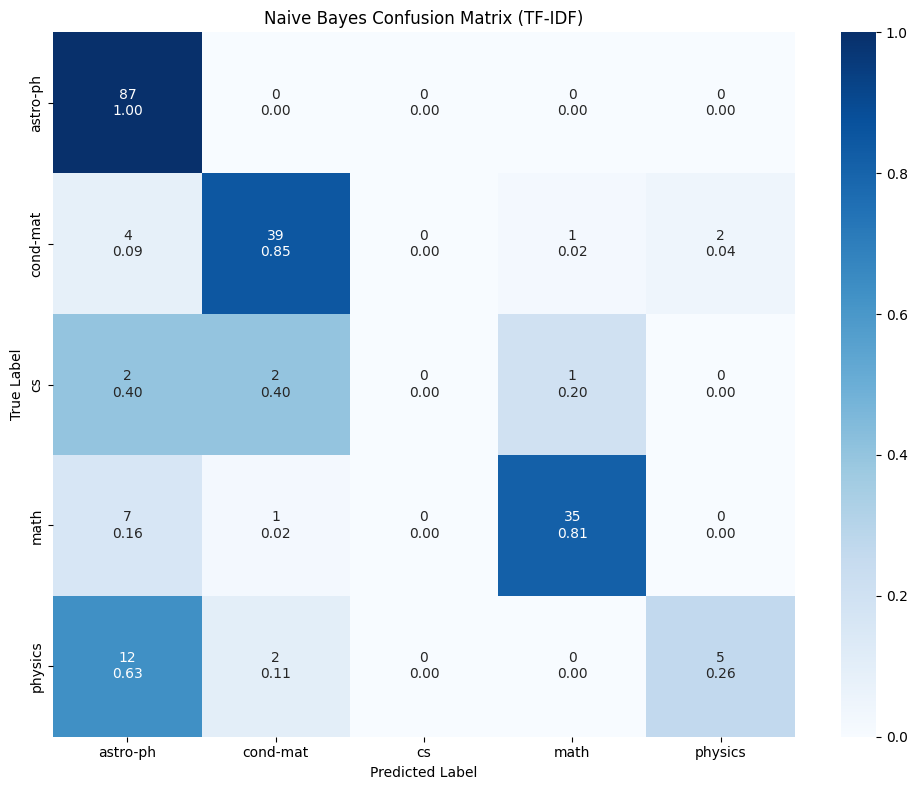

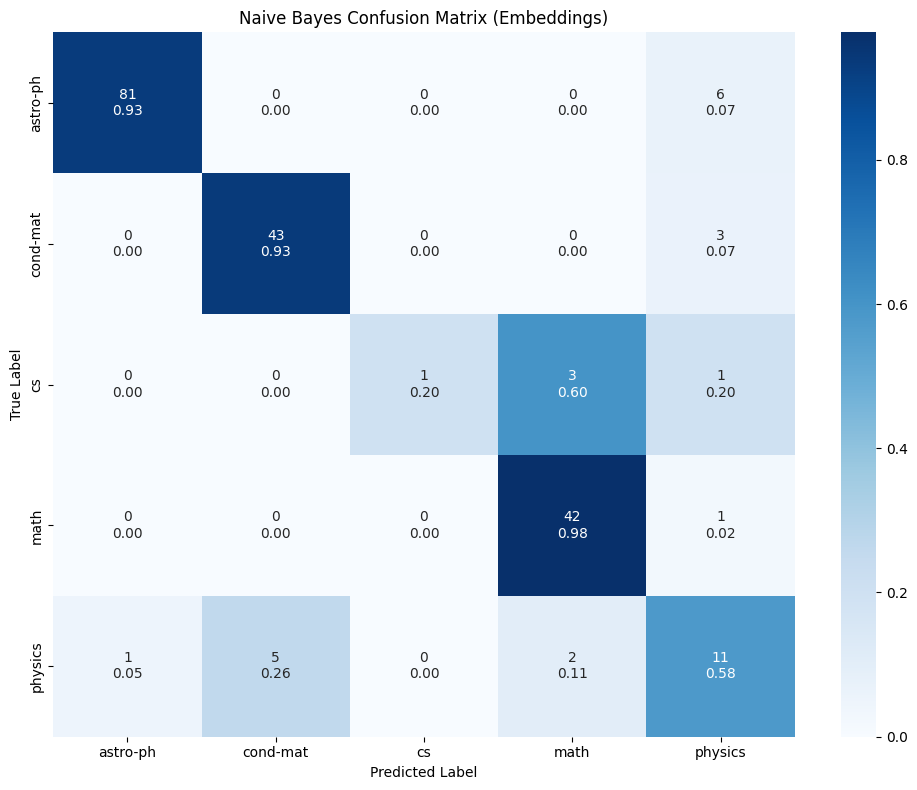

In [46]:
# Draw confusion matrices
plot_confusion_matrix(y_test, nb_bow_labels, sorted_labels, "Naive Bayes Confusion Matrix (Bag of Words)")

plot_confusion_matrix(y_test, nb_tfidf_labels, sorted_labels, "Naive Bayes Confusion Matrix (TF-IDF)")

plot_confusion_matrix(y_test, nb_embeddings_labels, sorted_labels, "Naive Bayes Confusion Matrix (Embeddings)")